# **Authors**

***The work can be done in groups of up to 3 students. Please complete the following fields with your group number and list your names and HDU ID numbers.***

> **[HDU-CS2-25] Computer Vision**
>
> 1. Абрамов Максим, 311786
> 2. Васильев Фёдор, 312227
> 3. Чакчир Дмитрий, 291704

The task and guidelines were prepared by Andrei Zhdanov and Sergei Shavetov, ITMO University, 2025.

# **Practical Assignment No 3. Feature Detectors**

***Study of feature point detectors and descriptors.***

To implement the current practical assignment task we would need OpenCV and NumPy libraries along with image display functions we wrote during the Image Processing class. We import OpenCV's `cv2` library as `cv` for easier use.

In [1]:
# Import OpenCV library as both cv2 and cv
import cv2
import cv2 as cv
# Import NumPy library as np
import numpy as np
# Import functions from our utility library
from pa_utils import ShowImages, exit

# **Introduction**

In this practical assignment, you will learn how to find, match, and use feature points for the image description. You will learn how to match two images and find the transformation matrix between them.

## Feature Points

First of all, we have to understand what are the image feature points. Let us look at Fig. 1.

| ![Building image](images/pa3_fig1.png "Building image") | 
|:--:| 
| ***Fig. 1.*** *Building image [1].* |

As you can see it has 6 patches (named by letters from $A$ to $F$). If you try searching for these patches on the source image you will find out that it's not possible to locate the position of patches $A$ and $B$ since they are taken somewhere from a repeating pattern of the sky or the building wall. If you look at patches $CD$ and $D$ you would also face a problem locating them since they are located somewhere at the edge of a building. However, if you take patches $E$ or $F$ you would easily locate them since they are corners. Such types of points that are easy to locate on an image are called feature points. From a formal point of view, feature points can be defined as points significantly different from their neighborhood. So, if you move a sliding window by one pixel from a feature point you would get a completely different image, see Fig. 2.

| ![Feature points](images/pa3_fig2.png "Feature points") | 
|:--:| 
| ***Fig. 2.*** *Feature points.* |

There are a lot of algorithms designed to detect and describe feature points, including: 
- Harris corner detector [2];
- Shi-Tomasi corner detector [3];
- Scale-Invariant Feature Transform (SIFT) detector and descriptor [4];
- Speeded-Up Robust Features (SURF) detector and descriptor [5];
- Features from Accelerated Segment Test (FAST) detector [6];
- Binary Robust Independent Elementary Features (BRIEF) descriptor [7];
- Oriented FAST and Rotated BRIEF (ORB) detector and descriptor [8].

In the current practical assignment, we will use SIFT and ORB feature point detectors and descriptors for image matching.

### References
1. Wagoner, A. R., Schrader, D. K., & Matson, E. T. (2017). Survey on detection and tracking of UAVs using computer vision. In 2017 First IEEE International Conference on Robotic Computing (IRC) (pp. 320–325). IEEE. https://doi.org/10.1109/IRC.2017.15
2. Harris, C., & Stephens, M. (1988). A combined corner and edge detector. In Alvey Vision Conference (Vol. 15, No. 50, pp. 10–5244). Citeseer.
3. Shi, J. (1994). Good features to track. In 1994 Proceedings of IEEE Conference on Computer Vision and Pattern Recognition (pp. 593–600). IEEE.
4. Lowe, D. G. (2004). Distinctive image features from scale-invariant keypoints. International Journal of Computer Vision, 60(2), 91–110. https://doi.org/10.1023/B:VISI.0000029664.99615.94
5. Bay, H., Tuytelaars, T., & Van Gool, L. (2006). SURF: Speeded up robust features. In European Conference on Computer Vision (pp. 404–417). Springer.
6. Viswanathan, D. G. (2009). Features from accelerated segment test (FAST). In Proceedings of the 10th Workshop on Image Analysis for Multimedia Interactive Services (pp. 6–8). London, UK.
7. Calonder, M., Lepetit, V., Strecha, C., & Fua, P. (2010). BRIEF: Binary robust independent elementary features. In European Conference on Computer Vision (pp. 778–792). Springer.
8. Rublee, E., Rabaud, V., Konolige, K., & Bradski, G. (2011). ORB: An efficient alternative to SIFT or SURF. In 2011 International Conference on Computer Vision (pp. 2564–2571). IEEE.

## SIFT Detector

SIFT stands for Scale-Invariant Feature Transform [1]. The algorithm was patented, however, in 2020 the patent expired, so now it can be used freely in any application.

One of the serious problems of traditional corner detectors, e.g., the Harris detector, is that they are not scale-invariant. Depending on the scale they may result in different feature points being detected, see Fig. 3.

| ![Dependence of the corner feature on the scale](images/pa3_fig3.png "Dependence of the corner feature on the scale") | 
|:--:| 
| ***Fig. 3.*** *Dependence of the corner feature on the scale.* |

To calculate the characteristic scale of feature points, the ideas of the Laplacian of Gaussian (LoG) method are used. It can be calculated as a scale-space maximum response of the Laplacian of Gaussian of an image with varying the $\sigma$ value, which is calculated by convolution of the variable-scale Gaussian $G(x, y, \sigma)$ with an input image $I(x, y)$:

$$
\begin{split}
  L(x, y, \sigma) &= G(x, y, \sigma) * I(x, y) \\
  G(x, y, \sigma) &= \frac{1}{2 \pi \sigma ^ 2}e^{\frac{-x^2 + y^2}{2 \sigma ^ 2}}
\end{split}
$$

where $*$ is a convolution operation in $x$ and $y$.

To detect scale-space maxima efficiently the Difference of Gaussian (DoG) method was proposed, which is computed with the following formula with a predefined constant multiplier $k$ by simple image subtraction, see Fig. 4:

$$
\begin{split}
  D(x, y, \sigma) &= (G(x, y, k \sigma) - G(x, y, \sigma)) * I(x, y) =\\
  &= L(x, y, k \sigma) - L(x, y, \sigma)
\end{split}
$$

| ![Difference of Gaussian calculation](images/pa3_fig4.png "Difference of Gaussian calculation") | 
|:--:| 
| ***Fig. 4.*** *Difference of Gaussian calculation.* |

The maxima of the DoG convolution for a pixel can be calculated by comparing a pixel with its 26 neighbors in current and adjacent scales as shown in Fig. 5.

| ![Selecting DoG maxima](images/pa3_fig5.png "Selecting DoG maxima") | 
|:--:| 
| ***Fig. 5.*** *Selecting DoG maxima.* |

After a point location and its characteristic scale is found its location is adjusted according to nearby image data. Low-contrast or poorly-localized points are filtered out since they are highly sensitive to noise.

Next, the characteristic orientation of the neighbor feature point patch is estimated by calculating a histogram of gradients of the patch and selecting a histogram maximum value. In cases where several strong maxima are detected, the feature point is considered several points with different orientations. The histogram contains 36 bins and covers $360^{\circ}$, see Fig. 6.

| ![Selecting the characteristic orientation](images/pa3_fig6.png "Selecting the characteristic orientation") | 
|:--:| 
| ***Fig. 6.*** *Selecting the characteristic orientation.* |

Then the patch is rotated according to the characteristic orientation and a descriptor is built by computing 16 histograms for $4 \times 4$ subwindows of a $16 \times 16$ pixels window around the feature point, see Fig. 7.

| ![SIFT descriptor](images/pa3_fig7.png "SIFT descriptor") | 
|:--:| 
| ***Fig. 7.*** *SIFT descriptor.* |

So, the SIFT descriptor contains 16 histograms, and each histogram contains 8 bins, which gives a total 128-dimensional vector for a feature point descriptor.

An estimation of similarity for two SIFT feature point descriptors is done with the Euclidean distance which is the standard L2 norm distance between two vector descriptors $\mathbf{a}$ and $\mathbf{b}$:

$$
d_{\text{Euclidean}}(\mathbf{a}, \mathbf{b}) = \sqrt{\sum_{i=1}^{n} (a_{i} - b_{i})^2}
$$

where
- $\mathbf{a} = [a_{1}, a_{2}, \dots, a_{n}]$ is the first SIFT descriptor;
- $\mathbf{b} = [b_{1}, b_{2}, \dots, b_{n}]$ is the second SIFT descriptor;
- $ a_i $ and $ b_i $ are the $ i $-th components of $ \mathbf{a} $ and $ \mathbf{b} $, respectively.
- $n$ is the descriptor length and is equal to $128$ for the SIFT descriptor.

In practice, the squared Euclidean distance can be used to increase the computation efficiency:

$$
d_{\text{SquaredEuclidean}}(\mathbf{a}, \mathbf{b}) = \sum_{i=1}^{n} (a_{i} - b_{i})^2
$$



### References
1. Lowe, D. G. (2004). Distinctive image features from scale-invariant keypoints. International Journal of Computer Vision, 60(2), 91–110. https://doi.org/10.1023/B:VISI.0000029664.99615.94


## ORB Detector

ORB detector [1] is a fusion of FAST feature point detector and BRIEF descriptor with many modifications to enhance the detector performance. At first, it uses the FAST detector to find feature points, then applies the Harris corner measure to find the top $N$-points among them. Secondly, it uses a pyramid to produce multiscale features. Since the FAST feature point detector is not rotation invariant the following method is used to calculate the characteristic rotation of the point: the intensity-weighted centroid of the patch with located corner at center is calculated. The direction of the vector from this corner point to the centroid is considered the orientation of the feature point. To improve the rotation invariance, moments are computed with $x$ and $y$ axes which should be in a circular region of radius $r$, where $r$ is the size of the patch.

ORB uses BRIEF descriptors for its feature points. The BRIEF descriptor [2] is a bit string description of an image patch constructed from a set of binary intensity tests:

$$
\tau(p, x, y) = 
\begin{cases}
  1, p(x) < p(y), \\
  0, p(x) \geqslant p(y).
\end{cases}
$$

Then the BRIEF feature point descriptor defined as a binary can be calculated from the set of simple binary intensity tests as follows:

$$
f_n(p) = \sum_{i=1}^{n}2^{i-1} \tau(p, x_i, y_i).
$$


To improve the performance of the BRIEF descriptor for rotated features, the descriptor is rotated according to the orientation of feature points. For any feature set of $n$ binary tests at location $(x_i,y_i)$, $S_{2 \times n}$ matrix is defined, which contains the coordinates of these pixels. 

$$
S = 
\begin{pmatrix}
  x_1, ..., x_n \\ y_1, ..., y_1
\end{pmatrix}.
$$

Then using the orientation $\theta$ of a patch its rotation matrix $R_\theta$ is calculated and used to rotate the $S$ matrix to get a rotated version $S_\theta$. 

$$
S_\theta = R_\theta S.
$$

ORB quantizes the angle to increments of $2\pi / 30 = 12\deg$, so a lookup table of precomputed BRIEF patterns can be calculated for each possible angle. As long as the keypoint orientation $\theta$ is consistent across views, the correct set of points $S_\theta$ will be used to compute its descriptor.

$$
g_n(p, \theta) = f_n(p)|(x_i, y_y) \in S_\theta.
$$

To compute a distance between two ORB descriptors $\mathbf{a}$ and $\mathbf{b}$ a Hamming distance is used (the Hamming distance is the number of positions at which the corresponding elements differ):

$$
d_{\text{Hamming}}(\mathbf{a}, \mathbf{b}) = \sum_{i=1}^{n} \mathbb{1}(a_i \neq b_i)
$$

where
- $ \mathbf{a} = [a_1, a_2, \dots, a_n] $ is the first ORB descriptor;
- $ \mathbf{b} = [b_1, b_2, \dots, b_n] $ is the second  ORB descriptor;
- $ a_i $ and $ b_i $ are the $ i $-th components of $ \mathbf{a} $ and $ \mathbf{b} $, respectively;
- $ \mathbb{1}(a_i \neq b_i) $ is an indicator function that equals 1 if $ a_i \neq b_i $, and 0 otherwise;
- $n$ is the descriptor length and is equal to $256$ bits for the ORB descriptor.

The multi-probe Locality-sensitive hashing (LSH) method may be used to accelerate ORB descriptor matching.

### References
1. Calonder, M., Lepetit, V., Strecha, C., & Fua, P. (2010). BRIEF: Binary robust independent elementary features. In European Conference on Computer Vision (pp. 778–792). Springer.
2. Rublee, E., Rabaud, V., Konolige, K., & Bradski, G. (2011). ORB: An efficient alternative to SIFT or SURF. In 2011 International Conference on Computer Vision (pp. 2564–2571). IEEE.

## Feature Point Descriptors Matching

The simplest way to match two sets of feature points is by using a brute force method. In this case, for each point of the first set, an item of the second set is selected which has the smallest distance. For SIFT descriptor you can use the Euclidean $L_2$ distance. As for the ORB descriptor, since it is a binary mask, the Hamming distance between descriptors should be used instead.

The brute force method works slowly. To speed up the descriptor matching an accelerating structure should be built on top of the descriptors set, then when matching a descriptor from the search query it is compared not with the whole set, but only with descriptors from some cluster. The simplest accelerating structure is KD-tree ($k$-dimensional tree) which is built on the space of training set descriptors. In case the descriptor is defined as a binary mask, then it is preferable to use the Locality-Sensitive Hashing (LSH) method.

Using the first best match may result in a lot of descriptor matches, however, a lot of them are false matches since some feature points are from repeating patterns (e.g., windows, water, clouds, etc.). There are two possible solutions to filter some of the not strong matches.

The first solution is to use cross-checking, which requires the descriptor to be matched in two directions: when matching two images it should be the best match in forward and backward directions.

The second solution is to use the $k$-nearest matching method. In this case, for each point, several best matches are found sorted by the distance, and the match is considered to be *good* if it is significantly different from the next nearest match, so the distance between the first nearest match is significantly lower compared to distance with the second nearest match:

$$
D_1 < r \cdot D_2,
$$

where 
- $D_1$ is the distance to the first nearest match;
- $D_2$ is the distance to the second nearest match;
- $r$ is difference ratio, which is advised to be $0.75$ by the SIFT method authors. 

Please note that the $k$-nearest matching method is not compatible with cross-checking since the cross-check does not allow more than one match to be found.

Using accelerating structures and $k$-nearest filtering we could get a set of strong matches between images. When matching descriptors we did not take the feature point positions into account, so the next step would be to calculate the geometric transformation between images taking into account that there may still be a lot of outliers or false matches. The most commonly used solution is to use the Random Sequence Consensus (RANSAC) method. The general idea of the method is to estimate not all data, but only a small sample, then build a hypothesis based on this sample and check how correct this hypothesis is. After checking a number of such hypotheses, we choose one that best fits with most of the data.


1. On input we have a set of pairs of matched feature point coordinates on two images: $S = \{(x, y)\} | x \in X, y \in Y$, where $X$ is a first image, and $Y$ is a second image.
2. For each $i$ from $1$ to $N$ build a hypothesis and check it:

    1. We build a hypothesis $\theta_i$ by selecting random pairs $S_i=\{(x_i, y_i)\} | (x_i, y_i) \in S$. In our case, it is enough to select 4 points from each of $X$ and $Y$ sets to build a matrix $M$ for the perspective transformation hypothesis.
    2. Evaluate the hypothesis $\theta_i$ by applying the perspective transformation matrix $M$ to all points of the first $X$ set and checking their matches with the points of the second $Y$ set with some threshold. The number of matches is the hypothesis evaluation score $R(\theta_I)$:
    $$
        \begin{split}
          R(\theta) &= \sum_{x \in X}p(\theta, x, Y), \\
          p(\theta, x, Y) &= 
            \begin{cases}
              1, |\varepsilon(\theta, x, Y)| \leqslant T, \\
              0, |\varepsilon(\theta, x, Y)| > T,
            \end{cases}
        \end{split}
    $$
    - where $\varepsilon(\theta, x)$ is the minimum distance from point $x$ to points of the set $Y$ with hypothesis $\theta$.

    3. If this is the first hypothesis, then store it as a current best hypothesis $\theta_0$. Else, check if the current hypothesis $\theta_i$ is better than the best one found before $\theta_0$, and, if so, then it is stored as the new best hypothesis.
    $$
        (i = 0) \lor (R(\theta_i) > R(\theta_0)) \Rightarrow \theta_0 = \theta_i.
    $$

3. After finishing $N$ iterations, the $\theta_0$ stores the best hypothesis. In our case, it is a perspective transformation matrix that transforms the first image into the coordinate system of the second image.


The probability of choosing at least one sample without outliers with the RANSAC method can be estimated as follows:
$$
  p = 1 - (1 - N (1 - e) ^ s) ^ N,
$$
where 
- $p$ is the probability of getting a good sample in N iterations;
- $N$ is the number of samples (iterations);
- $s$ is the number of points in the sample;
- $e$ is the ratio of outliers.

Since after estimating at least one hypothesis we can estimate the ratio of outliers, this allows us to estimate the required number of iterations based on the currently best hypothesis:

$$
  N = \frac{\log (1 - p)}{\log (1 - (1 - e) ^ s)}.
$$

The modification of the RANSAC method that uses $M$-estimator to evaluate the hypothesis is called M-SAC. In this case each point score $p(\theta, x, Y)$ depends on the minimum distance from point $x$ to points of the set $Y$ with hypothesis $\theta$:

$$
  \begin{split}
    R(\theta) &= \sum_{x \in X}p(\theta, x, Y), \\  
    p(\theta, x, Y) &= 
      \begin{cases}
        \varepsilon^2(\theta, x, Y), |\varepsilon(\theta, x, Y)| \leqslant T, \\
        T^2, |\varepsilon(\theta, x, Y)| > T.
      \end{cases}
  \end{split}
$$


# **Task 1. Feature Points Detection**

***Take three arbitrary images. Perform search for feature points using the SIFT and ORB feature point detectors.***

## **1.1 SIFT Feature Points Detector with OpenCV**

OpenCV provides a `cv2.SIFT` class to work with the SIFT feature point detector [1]. An instance of this class can be created by the `cv2.SIFT_create()` function. The constructor allows specifying additional detector parameters, e.g., the first parameter named `nfeatures` allows limiting the number of detected features to a specified number of the strong feature points. This class implements the `cv2.Feature2D` interface with the following functions used to detect feature points and compute their descriptors:

- `cv2.SIFT.detect(image, mask) -> keypoints` function detects feature points of the `image` with the region of interest (ROI) defined by `mask` and returns the `keypoints` list of detected feature points.
- `cv2.SIFT.compute(image, keypoints) -> fp, descriptors` function computes descriptors for a list feature points `fp` of the `image` and returns a tuple with feature points `fp` and `descriptors`. In case some descriptor can not be calculated it is being removed from the returned array. If two dominant orientations are found then the feature point is duplicated in the returned array with two separate descriptors.
- `cv2.SIFT.detectAndCompute(image, mask) -> keypoints, descriptors` function unites functions `detect()` and `compute()`. It detects feature points of the `image` with the region of interest defined by `mask`, computes their descriptors, and stores point to the list `keypoints` with the corresponding `descriptors` list.

After detecting, feature points can be displayed using `cv2.drawKeypoints(image, keypoints, outImage, color, flags) -> Iout` function. This function draws feature points defined by `keypoints` with a given `color` on the image `image` and stores it in the `outImage` image. If the output image is not specified then it is automatically created and returned. By default, the `color` of each feature point is different, and only the feature point position is displayed. The optional `flags` parameter value of `cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS` allows drawing feature point size and orientation as well.

### References
1. OpenCV. (2022). Introduction to SIFT (Scale-Invariant Feature Transform). Retrieved February 1, 2025, from https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

Let us try opening an image and displaying all feature points detected with OpenCV and SIFT detector in automatic mode.

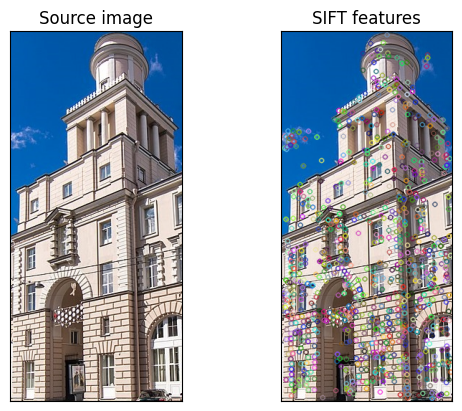

In [2]:
# Read an image from a file in BGR
fn = "images/tower.jpg"
I1 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I1, np.ndarray) or I1.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Convert to grayscale
I1gray = cv.cvtColor(I1, cv.COLOR_BGR2GRAY)

# Instantiate SIFT class object
sift = cv.SIFT_create()
# Detect SIFT feature points
I1fp = sift.detect(I1gray)

# Draw feature points (key points) on the image
I1sift_all = cv.drawKeypoints(I1, I1fp, None)

# Display it
ShowImages([("Source image", I1), 
            ("SIFT features", I1sift_all)], 2)

As you can see a lot of feature points were detected, but we can't understand the size and orientation of each feature. Let us try drawing them in rich format to show the characteristic scale and orientation of each feature point as well.

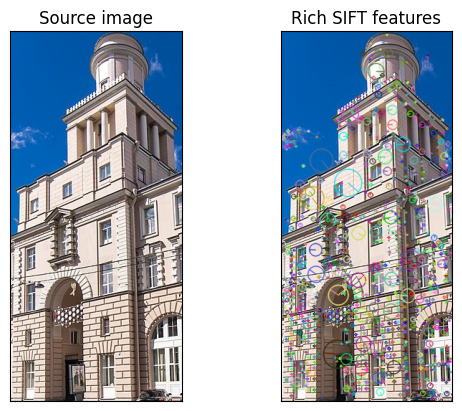

In [3]:
# Draw feature points (key points) on the image with a rich description
I1sift_all_rich = cv.drawKeypoints(I1, I1fp, None,
                        flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display it
ShowImages([("Source image", I1), 
            ("Rich SIFT features", I1sift_all_rich)], 2)

Now the image is overloaded with data, so let us limit the number of feature points to the top 100 strongest ones and display them in a rich format. In addition, we will specify the green feature points color to make them more noticeable on the image.

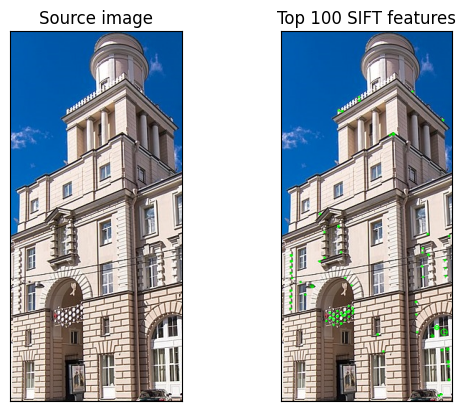

In [4]:
# Instantiate SIFT class object for 100 strongest features
sift = cv.SIFT_create(nfeatures = 100)
# Detect SIFT feature points
I1fp = sift.detect(I1gray)

# Draw feature points (key points) on the image and red color (to be used later in comparison)
I1sift_top = cv.drawKeypoints(I1, I1fp, None, color = (0, 0, 255))
# Draw feature points (key points) on the image with a rich description
I1sift_top_rich = cv.drawKeypoints(I1, I1fp, None, color = (0, 255, 0),
                                   flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display it
ShowImages([("Source image", I1), 
            ("Top 100 SIFT features", I1sift_top_rich)], 2)

As you can see, the resulting strongest feature points are exactly the corner points with corresponding scales. So, if we try searching for features on the same object with a bit different view angle or scale - the same points would be detected.

### **1.1.1 Self-work**

> ***Self-work***
>
> Take **three** arbitrary images and search for feature points with the SIFT detector. Display the detected points on the images.

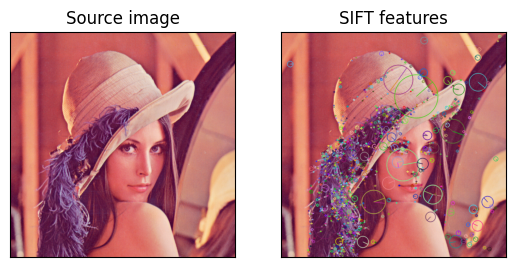

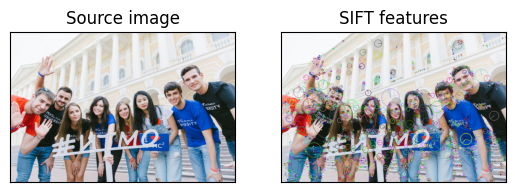

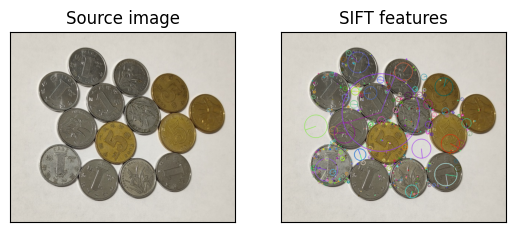

In [6]:
# TODO Place your solution here
def cift_with_keypoints(path):
    image = cv.imread(path, cv.IMREAD_COLOR)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_with_kp = cv.drawKeypoints(image, cv.SIFT_create().detect(gray), None,
                        flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return image, image_with_kp

paths = ["images/Task_1/1.png",
         "images/Task_1/2.jpg",
         "images/Task_1/3.jpg",]

for path in paths:
    img, img_kp = cift_with_keypoints(path)
    ShowImages([("Source image", img), 
            ("SIFT features", img_kp)], 2)


## **1.2 ORB Feature Points Detector with OpenCV**

Now let us try doing the same with the ORB detector. OpenCV provides a class named `cv2.ORB` for the detection of ORB feature points and the calculation of corresponding descriptors [1]. A class instance is created with `cv2.ORB_create()`. Additional constructor parameters allow modifying descriptor parameters, e.g., the first `nFeatures` parameter specifies the number of features to extract from an image. The class interface is the same as the SIFT detector and allows detecting feature points and computing their descriptors.

This class implements the same `cv2.Feature2D` interface with the `cv2.SIFT` class, so it implements the same set of functions to compute feature points and compute their descriptors.

### References
1. OpenCV. (2022). ORB (Oriented FAST and Rotated BRIEF). Retrieved February 1, 2025, from https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html

Let us do the same as we did for the SIFT detector but now for the ORB one:
- Display all feature points
- Display 100 strongest features with rich descriptions.

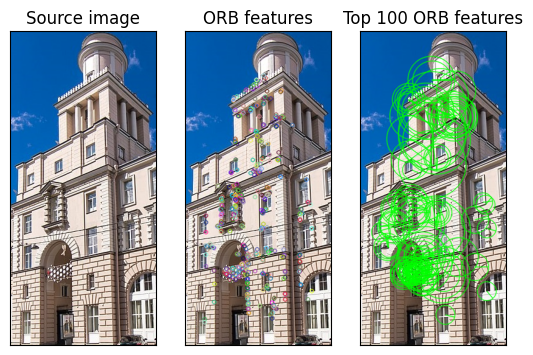

In [7]:
# Instantiate ORB class object
orb = cv.ORB_create()
# Detect ORB feature points
I1fp = orb.detect(I1gray)

# Draw feature points (key points) on the image
I1orb_all = cv.drawKeypoints(I1, I1fp, None)

# Instantiate ORB class object for 100 strongest features
orb = cv.ORB_create(nfeatures = 100)
# Detect SIFT feature points
I1fp = orb.detect(I1gray)

# Draw feature points (key points) on the image and red color (to be used later in comparison)
I1orb_top = cv.drawKeypoints(I1, I1fp, None, color = (0, 0, 255))
# Draw feature points (key points) on the image with a rich description
I1orb_top_rich = cv.drawKeypoints(I1, I1fp, None, color = (0, 255, 0),
                        flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display it
ShowImages([("Source image", I1), 
            ("ORB features", I1orb_all),
            ("Top 100 ORB features", I1orb_top_rich)], 3)

Now we can compare features detected by SIFT and ORB.

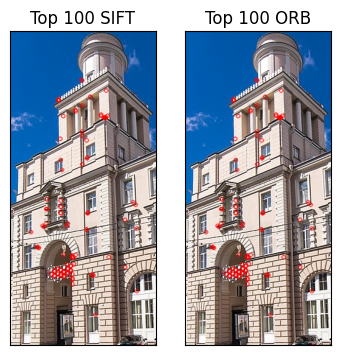

In [8]:
# Display it
ShowImages([("Top 100 SIFT", I1orb_top),
            ("Top 100 ORB", I1orb_top)], 3)

As you can see, the top feature points are very similar, doesn't matter which detector is used. However, later you will see that feature point descriptors make some difference.

### **1.2.1 Self-work**

> ***Self-work***
>
> Take the same **three** images that you used with the SIFT detector and search for feature points with the ORB detector. Display the detected points on the images. Compare top SIFT and ORB feature points.

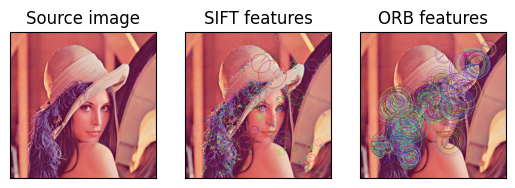

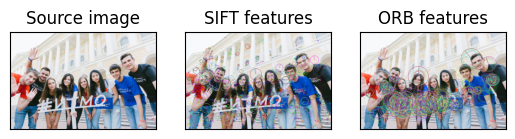

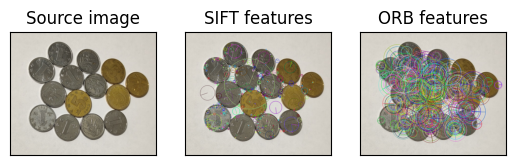

In [10]:
# TODO Place your solution here
def orb_with_keypoints(path):
    image = cv.imread(path, cv.IMREAD_COLOR)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_with_kp = cv.drawKeypoints(image, cv.ORB_create().detect(gray), None, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return image, image_with_kp

for path in paths:
    img, img_kp_sift = cift_with_keypoints(path)
    _, img_kp_orb = orb_with_keypoints(path)
    ShowImages([("Source image", img), 
            ("SIFT features", img_kp_sift), 
            ("ORB features", img_kp_orb)], 3)


# **Task 2. Feature Points Matching**

***Take two pairs of images: the first image of each pair should have an object (e.g., some book) and the second image should be a scene containing this object. Extract the feature points of an object and match them with the feature points of a scene containing this object. Calculate the transformation matrix using the RANSAC method and highlight the object position in the scene. Show the inlier matches. Compare feature point descriptors for the task of image matching.***

Let us try searching for objects with the OpenCV library. So, we will take a pair of images of an object and the scene with this object. In our case, this will be the tower of the main building of ITMO University and a photo of the whole building. They are shot from a bit different angles, but the same feature points can be found on both of the images. Since the two views have different affine geometric transformations, our goal is to match the object with the whole scene and find this transformation.

This task is done in the following steps:
1. Detect feature points on two images and compute descriptors for them.
2. Match detected feature points.
3. Find the transformation between two images by searching for a transformation matrix that fits these matches best.

## 2.1 Detect feature points on two images and compute descriptors

At first, we have to load images and detect feature points. It's worth using the `detectAndCompute()` function to calculate feature point descriptors along with their detection. We will use the SIFT descriptor for the feature points search.


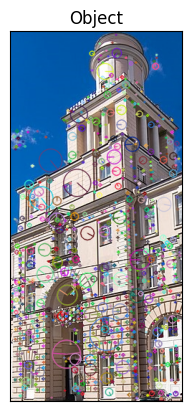

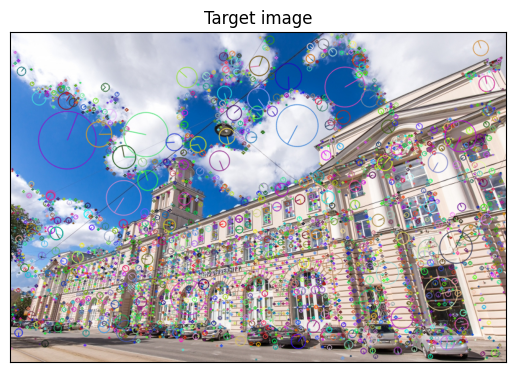

In [11]:
# Read the first image from a file in BGR
fn1 = "images/tower.jpg"
I1 = cv.imread(fn1, cv.IMREAD_COLOR)
if not isinstance(I1, np.ndarray) or I1.data == None:
  print("Error reading file \"{}\"".format(fn1))
  exit()

# Read the second image from file in BGR
fn2 = "images/building.jpg"
I2 = cv.imread(fn2, cv.IMREAD_COLOR)
if not isinstance(I2, np.ndarray) or I2.data == None:
  print("Error reading file \"{}\"".format(fn2))
  exit()

# Convert to grayscale
I1gray = cv.cvtColor(I1, cv.COLOR_BGR2GRAY)
I2gray = cv.cvtColor(I2, cv.COLOR_BGR2GRAY)

# Instantiate SIFT class object
sift = cv.SIFT_create()

# Detect and compute SIFT feature points
I1fp, I1des = sift.detectAndCompute(I1gray, None)
I2fp, I2des = sift.detectAndCompute(I2gray, None)

# Draw feature points (key points) on the image with a rich description
I1sift_all_rich = cv.drawKeypoints(I1, I1fp, None,
                                   flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
I2sift_all_rich = cv.drawKeypoints(I2, I2fp, None,
                                   flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display it
ShowImages([("Object", I1sift_all_rich), 
            ("Target image", I2sift_all_rich)])

## 2.2 Match detected feature points

After feature points are detected and their descriptors are computed, the next step is to match feature point descriptors on the object image with descriptors on the target image. OpenCV provides two feature point descriptor matchers:

- `cv2.BFMatcher` class implements the brute force matcher. For each feature point descriptor of the first set of points, it finds the best match in the second set by iterating through all its feature point descriptors. The class constructor has two parameters:
    - `normType` sets the matcher distance calculation method. The default value is Euclidean L2 distance specified by `cv2.NORM_L2` which fits SIFT descriptors. In the case of ORB descriptors, it's better to use the Hamming distance which can be specified by `cv2.NORM_HAMMING`.
    - `crossCheck` sets if the cross-checks filter should be used. By default, it is Off.
- `cv2.FlannBasedMatcher` class is the implementation of Fast Library for Approximate Nearest Neighbors matcher. It uses different algorithms for accelerated feature point descriptors matching (KD-trees, $k$-means, LSH, etc.).

All OpenCV feature point matchers implement the `cv2.DescriptorMatcher` interface. It has two main matching functions:
- `match(queryDescriptors, trainDescriptors) -> matches` class method matches descriptors `queryDescriptors` and `trainDescriptors`. For each descriptor in `queryDescriptors` a single best match is found in the `trainDescriptors`. This match is returned in the `matches` array.
- `match(queryDescriptors, trainDescriptors, k) -> matches` class method matches $k$-nearest descriptors `queryDescriptors` and `trainDescriptors`. For each descriptor in `queryDescriptors`, the $k$ best matches are found in the `trainDescriptors` and are returned in the `matches` array. Each item of the `matches` array is an array containing the strongest $k$ matches for each feature point. Please note that the $k$-nearest matching method is not compatible with the cross-check in the brute force matcher since the cross-check does not allow more than one match to be found.

Each match in the returned `matches` array is an instance of the `cv2.DMatch` class containing the following fields:
- `queryIdx` is an index of the feature point in the query feature points set (`queryDescriptors`);
- `trainIdx` is an index of the feature point in the train feature points set (`trainDescriptors`);
- `imgIdx` is an index of the image in the train feature points images set;
- `distance` is a distance measure between these two descriptors.

The `cv2.DescriptorMatcher` interface also has functions that can be used to train a matcher on a set of images with corresponding descriptors to match a single query (`queryDescriptors` in our case) with a set of image descriptors (instead of single `trainDescriptors`). This is the reason for the index returned in the `imgIdx` parameter of the `cv2.DMatch` class. However, since we are matching only two images we don't need this extra information.

Let us create these two matchers and match feature points without cross-checking.

In [12]:
# Create a brute force matcher
bf_matcher = cv.BFMatcher(normType = cv.NORM_L2, crossCheck = False)
# And match descriptors
bf_matches = bf_matcher.match(I1des, I2des)

# Create a FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann_matcher = cv.FlannBasedMatcher(index_params, search_params)
# And match descriptors
flann_matches = flann_matcher.match(I1des, I2des)

When using the ORB descriptor and FLANN matcher, the LSH algorithm should be used. It can be done as follows:

```python
# Set the FLANN parameters
FLANN_INDEX_LSH = 6
index_params = dict(algorithm = FLANN_INDEX_LSH,
                    table_number = 6,
                    key_size = 12,
                    multi_probe_level = 1)
search_params = dict(checks = 50)

# Create matcher
flann_lsh_matcher = cv2.FlannBasedMatcher(index_params, search_params)
```

Now we can use `cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches1to2, outImg, matchColor, singlePointColor, matchesMask, flags)` function to display found matches. It combines images `img1` and `img2` into a single image, draws feature points `keypoints1` and `keypoints2` on them, and connects the matched ones with lines according to the `matches1to2` matches list. Optional parameters allow specifying the match connection line color, non-matched feature points color, mask for match visualization, and extra visualization `flags` (we will use `cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS` flag to exclude not matched points from visualization).

To display only top matches the `matches` array which we acquired after descriptor matching can be sorted by the `distance` value and its top part can be visualized either by matches array slicing or by specifying a mask for match drawing.

Let us do it.

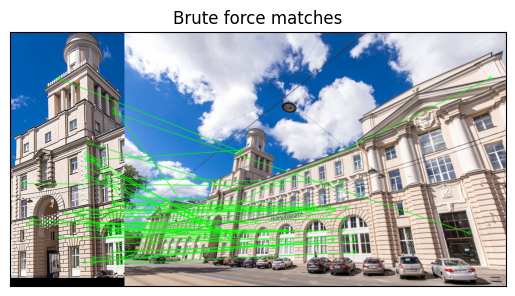

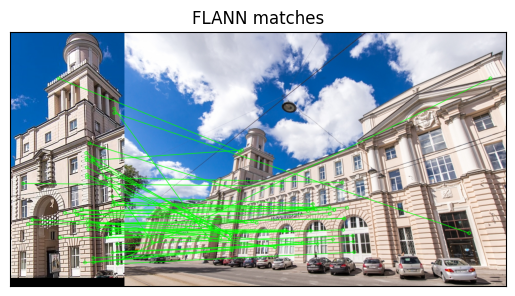

In [13]:
# Define a parameter for a count of matches to visualize
num_matches = 50

# Create an image with brute force matches
matches = sorted(bf_matches, key = lambda x:x.distance)
I1bf_match = cv.drawMatches(I1, I1fp, I2, I2fp, matches, None, 
                            matchesMask = [1 if i < num_matches else 0 for i in range(len(matches))],
                            flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                            matchColor = (0,255,0))

# Create an image with FLANN matches
matches = sorted(flann_matches, key = lambda x:x.distance)
I1flann_match = cv.drawMatches(I1, I1fp, I2, I2fp, matches, None, 
                               matchesMask = [1 if i < num_matches else 0 for i in range(len(matches))],
                               flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                               matchColor = (0,255,0))

# Display it
ShowImages([("Brute force matches", I1bf_match), 
            ("FLANN matches", I1flann_match)])

As it can be seen from feature points matching results, using the first best match may result in a lot of descriptor matches and a lot of false matches among them. 

When using the brute force matcher we can add the cross-check operation as well to increase the match quality. Let us try it.

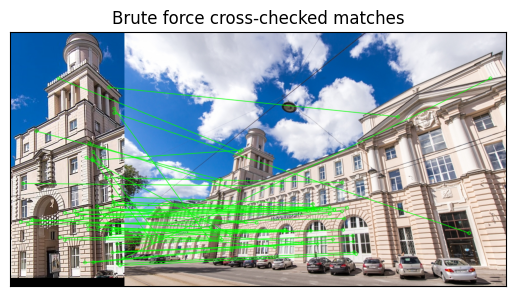

In [14]:
# Create a brute force matcher with cross-checking
bf_cc_matcher = cv.BFMatcher(crossCheck = True)
# And match descriptors
bf_cc_matches = bf_cc_matcher.match(I1des, I2des)

# Create an image with brute force cross-checked matches
matches = sorted(bf_cc_matches, key = lambda x:x.distance)
I1bf_cc_match = cv.drawMatches(I1, I1fp, I2, I2fp, matches, None, 
                               matchesMask = [1 if i < num_matches else 0 for i in range(len(matches))],
                               flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                               matchColor = (0,255,0))

# Display it
ShowImages([("Brute force cross-checked matches", I1bf_cc_match)])

Another solution is to use the $k$-nearest matching to filter some of the detected matches. In this case, the match is considered to be *good* if it is significantly different from the next nearest match, so the distance between the first nearest match is significantly lower compared to the distance with the second nearest match. 

Let us try it as well.

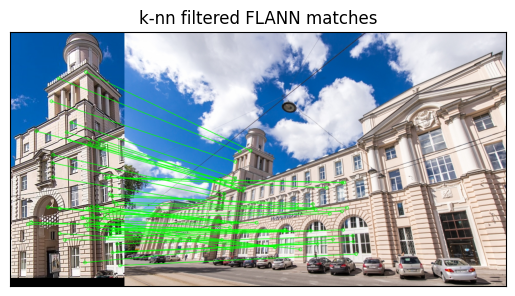

In [15]:
# We will use FLANN matcher for this
flann_knn_matches = flann_matcher.knnMatch(I1des, I2des, k = 2)

# This is the ratio between the first and second match to select the first one
knn_ratio = 0.75

# Select good matches only
good = []
for m in flann_knn_matches:
  if len(m) > 1:
    if m[0].distance < knn_ratio * m[1].distance:
      good.append(m[0])
flann_knn_matches = good

# Create an image with k-nn filtered matches
matches = sorted(flann_knn_matches, key = lambda x:x.distance)
I1flann_knn_match = cv.drawMatches(I1, I1fp, I2, I2fp, matches, None, 
                                   matchesMask = [1 if i < num_matches else 0 for i in range(len(matches))],
                                   flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                                   matchColor = (0,255,0))

# Display it
ShowImages([("k-nn filtered FLANN matches", I1flann_knn_match)])

## 2.3 Find the transformation matrix

Now we have a set of matching feature points on two images, but they don't form any transformation as they still have outliers. So, we have to filter the outliers out and calculate the transformation matrix between two sets of matched feature points. This can be done by the *RANSAC* (RANdom SAmples Consensus) algorithm implemented in OpenCV `cv2.findHomography(srcPoints, dstPoints, method, ransacReprojThreshold, mask, maxIters, confidence) -> H, mask` function with `cv2.RANSAC` value for `method` parameter [1]. This function calculates the homography transformation matrix `H` for the perspective transformation from the coordinate system of the first image `srcPoints` to the second image `dstPoints`. The inliers and outliers of the best RANSAC hypothesis are marked in the returned `mask`. Optional parameters allow specifying the RANSAC threshold value (`ransacReprojThreshold` parameter, defaults to $3$), the maximum number of iterations in RANSAC (`maxIters` parameter, default to $2000$), and `confidence` level (defaults to $0.995$).

The OpenCV implementation of the RANSAC method requires at least 10 matches to work, so this should be checked before the call.

### References
1. 1. OpenCV. (2022). Feature Matching + Homography to find Objects. Retrieved February 1, 2025, from https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

Since we already have found matches, so now we can execute the RANSAC method to find the homography matrix.

Let us do it for matches found with the SIFT descriptor and brute force matcher with cross-checking.

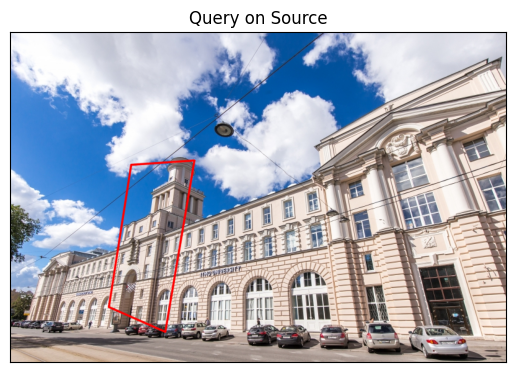

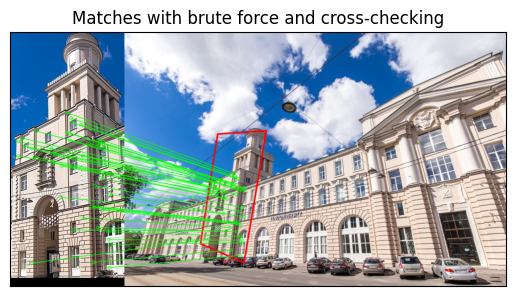

In [16]:
# First we have to check that we have the required minimum of 10 matches
MIN_MATCH_COUNT = 10
if len(bf_cc_matches) < MIN_MATCH_COUNT:
  print("Not enough matches to calculate the homography matrix.")
else:
  # Create arrays of coordinates in two images
  matches = sorted(bf_cc_matches, key = lambda x:x.distance)
  I1pts = np.float32([I1fp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  I2pts = np.float32([I2fp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  # Run the RANSAC method to find the transformation
  H, mask = cv.findHomography(I1pts, I2pts, cv.RANSAC, 5)

  if H is None:
    print("Homography matrix was not found.")
  else:
    mask = mask.ravel().tolist()

    # Calculate a rectangle of the first image in the second CS
    # For this we define four corner points and transom them with the homography matrix
    h, w = I1.shape[:2]
    I1box = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    I1to2box = cv.perspectiveTransform(I1box, H)

    # Now when we have the coordinates of the first image corners in the coordinate system
    # of the second image, we can highlight the object on the second image
    I2res = I2.copy()
    cv.polylines(I2res, [np.int32(I1to2box)], True, (0, 0, 255), 2, cv.LINE_AA)

    # Draw found good matches with found transformation
    I2trans = cv.drawMatches(I1, I1fp, I2res, I2fp, matches, None, matchesMask = mask, 
                            flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                            matchColor = (0,255,0))
    
    # Display an image
    ShowImages([("Query on Source", I2res),
                ("Matches with brute force and cross-checking", I2trans)])


### **2.3.1 Self-work**

> ***Self-work***
>
> Take the three remaining match sets found in the example and find the homography matrices:
> 1. `bf_matches` for brute force matches filtered without cross-checking;
> 2. `flann_matches` for FLANN matches;
> 3. `knn_matches` for FLANN matches filtered with tolerancing $k$-nn matches.
>
> If the object is found then highlight the object position in the scene and show inlier matches. Was the object found correctly?

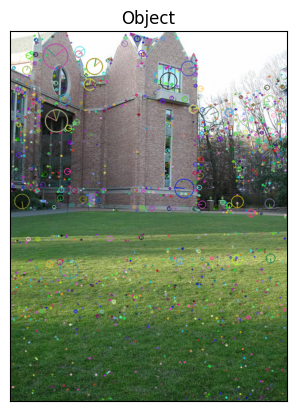

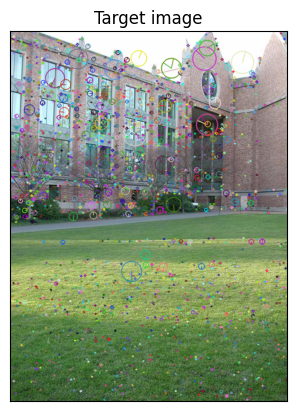

In [18]:
# TODO Place your solution here
# Read the first image from a file in BGR
fn1 = "pano/campus_016.jpg"
I1 = cv.imread(fn1, cv.IMREAD_COLOR)
if not isinstance(I1, np.ndarray) or I1.data == None:
  print("Error reading file \"{}\"".format(fn1))
  exit()

# Read the second image from file in BGR
fn2 = "pano/campus_017.jpg"
I2 = cv.imread(fn2, cv.IMREAD_COLOR)
if not isinstance(I2, np.ndarray) or I2.data == None:
  print("Error reading file \"{}\"".format(fn2))
  exit()

# Convert to grayscale
I1gray = cv.cvtColor(I1, cv.COLOR_BGR2GRAY)
I2gray = cv.cvtColor(I2, cv.COLOR_BGR2GRAY)

# Instantiate SIFT class object
sift = cv.SIFT_create()

# Detect and compute SIFT feature points
I1fp, I1des = sift.detectAndCompute(I1gray, None)
I2fp, I2des = sift.detectAndCompute(I2gray, None)

# Draw feature points (key points) on the image with a rich description
I1sift_all_rich = cv.drawKeypoints(I1, I1fp, None,
                                   flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
I2sift_all_rich = cv.drawKeypoints(I2, I2fp, None,
                                   flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display it
ShowImages([("Object", I1sift_all_rich), 
            ("Target image", I2sift_all_rich)])

[[  0.   0.   0. ...  24.  15.  14.]
 [  0.   0.   2. ...   0.   2.   1.]
 [  0.   0.   4. ...  15.   3.   5.]
 ...
 [  3.   2.   1. ...   4.   2.  24.]
 [  3.  38. 108. ...   0.   0.   0.]
 [ 20.   6.   0. ...   0.   0.   0.]]


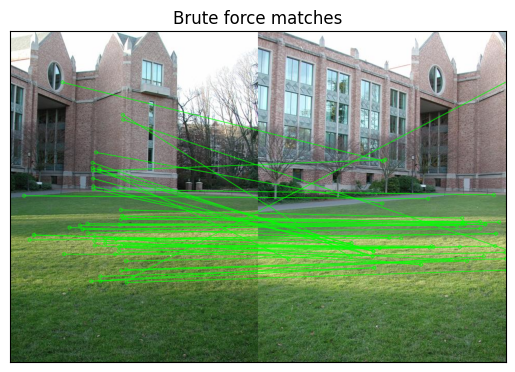

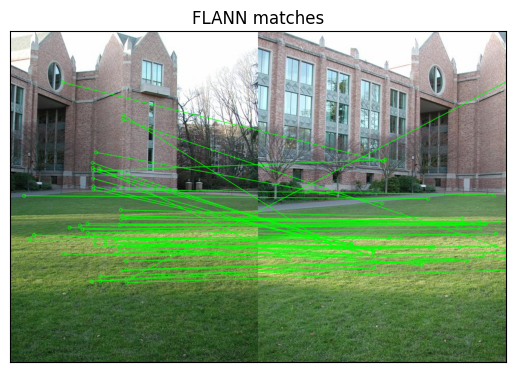

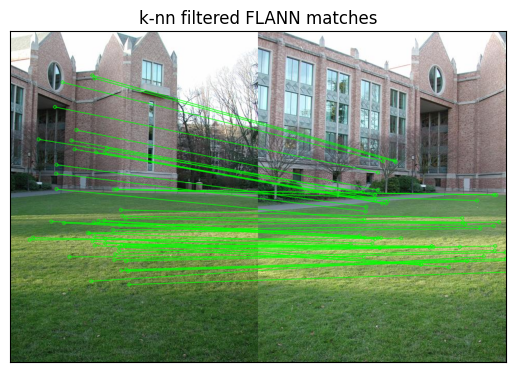

In [37]:
# Create a brute force matcher
bf_matcher = cv.BFMatcher(normType = cv.NORM_L2, crossCheck = False)
# And match descriptors
bf_matches = bf_matcher.match(I1des, I2des)

# Create a FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann_matcher = cv.FlannBasedMatcher(index_params, search_params)
# And match descriptors
flann_matches = flann_matcher.match(I1des, I2des)

# Define a parameter for a count of matches to visualize
num_matches = 50

# Create an image with brute force matches
matches = sorted(bf_matches, key = lambda x:x.distance)
I1bf_match = cv.drawMatches(I1, I1fp, I2, I2fp, matches, None, 
                            matchesMask = [1 if i < num_matches else 0 for i in range(len(matches))],
                            flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                            matchColor = (0,255,0))

# Create an image with FLANN matches
matches = sorted(flann_matches, key = lambda x:x.distance)
I1flann_match = cv.drawMatches(I1, I1fp, I2, I2fp, matches, None, 
                               matchesMask = [1 if i < num_matches else 0 for i in range(len(matches))],
                               flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                               matchColor = (0,255,0))

# Display it
ShowImages([("Brute force matches", I1bf_match), 
            ("FLANN matches", I1flann_match)])

# We will use FLANN matcher for this
flann_knn_matches = flann_matcher.knnMatch(I1des, I2des, k = 2)

# This is the ratio between the first and second match to select the first one
knn_ratio = 0.75

# Select good matches only
good = []
for m in flann_knn_matches:
  if len(m) > 1:
    if m[0].distance < knn_ratio * m[1].distance:
      good.append(m[0])
flann_knn_matches = good

# Create an image with k-nn filtered matches
matches = sorted(flann_knn_matches, key = lambda x:x.distance)
I1flann_knn_match = cv.drawMatches(I1, I1fp, I2, I2fp, matches, None, 
                                   matchesMask = [1 if i < num_matches else 0 for i in range(len(matches))],
                                   flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                                   matchColor = (0,255,0))

# Display it
ShowImages([("k-nn filtered FLANN matches", I1flann_knn_match)])

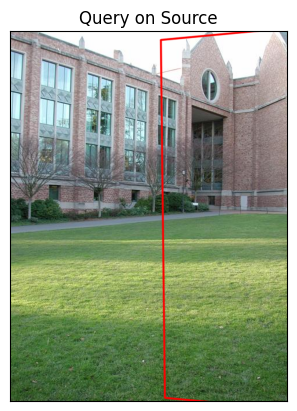

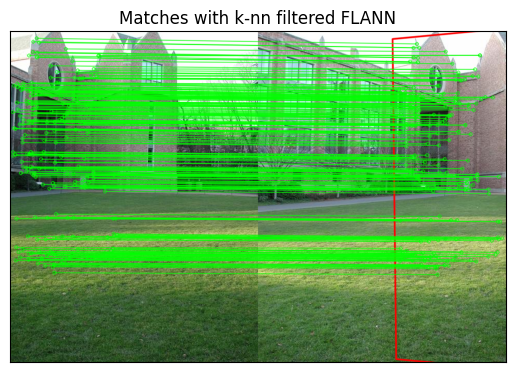

In [25]:
# First we have to check that we have the required minimum of 10 matches
MIN_MATCH_COUNT = 10
if len(flann_knn_matches) < MIN_MATCH_COUNT:
  print("Not enough matches to calculate the homography matrix.")
else:
  # Create arrays of coordinates in two images
  matches = sorted(flann_knn_matches, key = lambda x:x.distance)
  I1pts = np.float32([I1fp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  I2pts = np.float32([I2fp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  # Run the RANSAC method to find the transformation
  H, mask = cv.findHomography(I1pts, I2pts, cv.RANSAC, 5)

  if H is None:
    print("Homography matrix was not found.")
  else:
    mask = mask.ravel().tolist()

    # Calculate a rectangle of the first image in the second CS
    # For this we define four corner points and transom them with the homography matrix
    h, w = I1.shape[:2]
    I1box = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    I1to2box = cv.perspectiveTransform(I1box, H)

    # Now when we have the coordinates of the first image corners in the coordinate system
    # of the second image, we can highlight the object on the second image
    I2res = I2.copy()
    cv.polylines(I2res, [np.int32(I1to2box)], True, (0, 0, 255), 2, cv.LINE_AA)

    # Draw found good matches with found transformation
    I2trans = cv.drawMatches(I1, I1fp, I2res, I2fp, matches, None, matchesMask = mask, 
                            flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                            matchColor = (0,255,0))
    
    # Display an image
    ShowImages([("Query on Source", I2res),
                ("Matches with k-nn filtered FLANN", I2trans)])

## **2.4 Self-work**

>  ***Self-work***
>
> Take **two** arbitrary **pairs** of images: the first image of each pair should have an object (e.g., some book) and the second image should be a scene containing this object. Extract the feature points of an object and match them with the feature points of a scene containing this object. Calculate the transformation matrix using the RANSAC method and highlight the object position in the scene. Show the inlier matches. Display the results.
>
> The task should be completed with **both** SIFT and ORB detectors. You may select any feature points matching algorithm.
>
> ***Notes.***
> 1. *When using the brute force matcher for ORB descriptors, it should be created with the Hamming distance norm.*
> 2. *It is suggested to use cross-checking for the brute force matcher with ORB.*
>     ```python
>     bf_hamming_cc_matcher = cv.BFMatcher(normType = cv.NORM_HAMMING, crossCheck = False)
>     ```
> 3. *When using the FLANN matcher for ORB descriptors, it should be created with the LSH algorithm.*
>     ```python
>     # Set the FLANN parameters
>     FLANN_INDEX_LSH = 6
>     index_params = dict(algorithm = FLANN_INDEX_LSH,
>                         table_number = 6,
>                         key_size = 12,
>                         multi_probe_level = 1)
>     search_params = dict(checks = 50)
>     # Create matcher
>     flann_lsh_matcher = cv2.FlannBasedMatcher(index_params, search_params)
>     ```
>

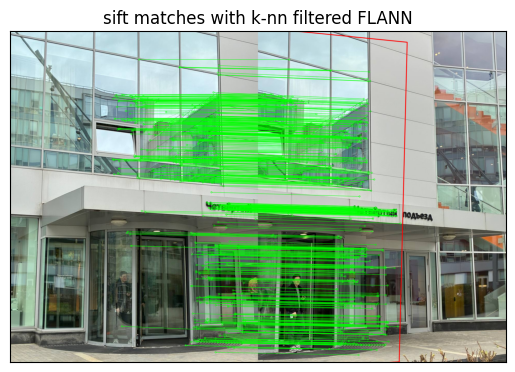

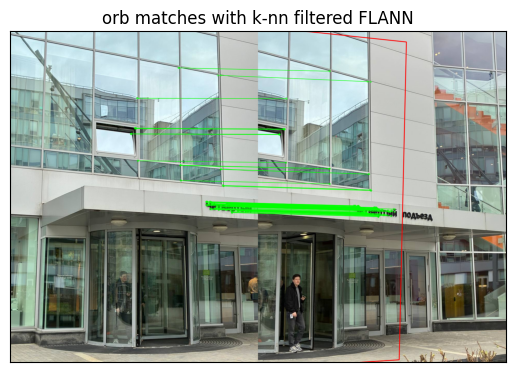

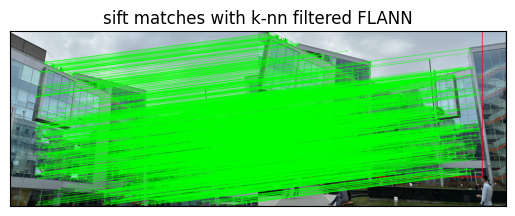

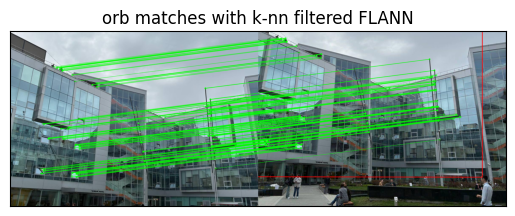

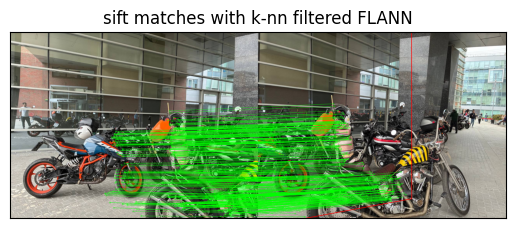

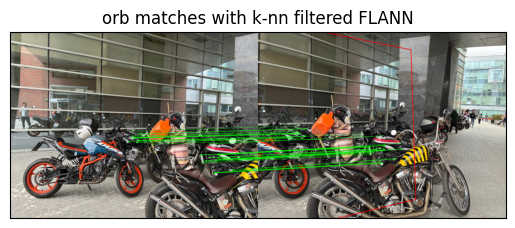

In [59]:
# TODO Place your solution here
def get_keypoints(image, method):
    return method.detectAndCompute(cv.cvtColor(image, cv.COLOR_BGR2GRAY), None)

def transformation_matrix(image_1, image_2, fp_image_1, fp_image_2, matches):
    MIN_MATCH_COUNT = 10
    if len(matches) < MIN_MATCH_COUNT:
      print("Not enough matches to calculate the homography matrix.")
    else:
      # Create arrays of coordinates in two images
        matches = sorted(matches, key = lambda x:x.distance)
        I1pts = np.float32([fp_image_1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        I2pts = np.float32([fp_image_2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
      # Run the RANSAC method to find the transformation
        H, mask = cv.findHomography(I1pts, I2pts, cv.RANSAC, 5)
        
        if H is None:
            print("Homography matrix was not found.")
        else:
            mask = mask.ravel().tolist()
        
        # Calculate a rectangle of the first image in the second CS
        # For this we define four corner points and transom them with the homography matrix
        h, w = image_1.shape[:2]
        I1box = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        I1to2box = cv.perspectiveTransform(I1box, H)
        
        # Now when we have the coordinates of the first image corners in the coordinate system
        # of the second image, we can highlight the object on the second image
        I2res = image_2.copy()
        cv.polylines(I2res, [np.int32(I1to2box)], True, (0, 0, 255), 2, cv.LINE_AA)
        
        # Draw found good matches with found transformation
        return cv.drawMatches(image_1, I1fp, I2res, I2fp, matches, None, matchesMask = mask, 
                                flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                                matchColor = (0,255,0))
        
        
def count_knn_flann_matches(I1des, I2des, index_params, search_params):
    # Create a brute force matcher
    flann_matcher = cv.FlannBasedMatcher(index_params, search_params)    
    matches = flann_matcher.knnMatch(I1des, I2des, k = 2)
    knn_ratio = 0.75
    
    good = []
    for m in matches:
      if len(m) > 1:
        if m[0].distance < knn_ratio * m[1].distance:
          good.append(m[0])
    matches = good
    
    # Create an image with k-nn filtered matches
    return sorted(matches, key = lambda x:x.distance)
      
methods = {"sift": cv.SIFT_create(),
          "orb": cv.ORB_create()}

flann_params = {"sift": {"index_params": dict(algorithm = 1, trees = 5),
                         "search_params": dict(checks = 50)},
                "orb": {"index_params": dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 1),
                        "search_params": dict(checks = 50)}}

pairs = [("images/Task_2/example1_1.jpeg","images/Task_2/example1_2.jpeg"),
         ("images/Task_2/example2_1.jpeg","images/Task_2/example2_2.jpeg"),
         ("images/Task_2/example6_1.jpeg","images/Task_2/example6_2.jpeg")
         ]
for path_1, path_2 in pairs:
    image_1 = cv.imread(path_1)
    image_2 = cv.imread(path_2)
    
    output = []
    for name, method in methods.items():
        I1fp, I1des = get_keypoints(image_1, method)
        I2fp, I2des = get_keypoints(image_2, method)
        
        matches = count_knn_flann_matches(I1des, I2des, **flann_params[name])
        res = transformation_matrix(image_1, image_2, I1fp, I2fp, matches)
        
        ShowImages([(f"{name} matches with k-nn filtered FLANN", res)])  


# **Task 3. Optional**

***Implement the simple automatic image stitching. Use learned methods to calculate the transformation matrix between two images and stitch them into a single panoramic image. Use it to stitch three images into a single panoramic image. You may assume that the order of the images is known (e.g., all three images are shot while moving the camera from left to right), so reordering is not required.***

Let us consider that you have three images ($left$, $right$, and $middle$) and you want to stitch them. In order to implement the automatic image stitching algorithm in its simplest form you have to do the following steps:
1. Create an empty canvas and place the $middle$ image in the center. This will be the canvas where you add other images.
2. Calculate the homography matrix for transformation from the $left$ image to the canvas.
3. Transform the $left$ image with this transformation matrix and place it on areas with black color on the canvas.
4. Do the same for the $right$ image.

***Notes.*** 
1. *This is the simplest approach, so corners may be cut when stitching.*
2. *Since parts of the panoramic images are shot with different exposition parameters, they may slightly differ in lightness. In the scope of this task, this should not be taken into account.*

## **3.1 Self-work (optional)**

> ***Self-work (optional)***
> 
> Implement the simple automatic image stitching for three images. Display the result.

In [ ]:
# TODO Place your solution here


 # **Questions**

***Please answer the following questions:***

 - *How can the characteristic orientation (rotation) of the feature point be estimated?*
 > Ориентация вычисляется через анализ градиентов в окрестности точки (алгоритм SIFT или ORB)
 >
 >

 - *How to filter the not-strong feature point descriptor matches on a repeating texture (e.g., windows, water, etc.) out?*
 > Используйте ratio-тест для отсева неоднозначных соответствий и RANSAC для проверки геометрической согласованности.
 >
 >

 - *What is the minimum required sample size (the number of matched pairs of feature points) to build an affine transformation hypothesis with the RANSAC method? What is the minimum required sample size to build a perspective transformation hypothesis with the RANSAC method?*
 > Для Аффинного преобразования 3 пары точек, а для Перспективного 4 пары точек
 >
 >

 - *How to use feature points for stitching a panoramic image?*
 > 1. Найти и сопоставить ключевые точки между изображениями.
> 2. Вычислить гомографию с помощью RANSAC.
> 3. Спроецировать и сшить изображения с учетом найденного преобразования.
 >
 >

# **Conclusion**

***What have you learned with this task? Don't forget to conclude it.***

 > В ходе практической работы были изучены и применены на практике алгоритмы поиска ключевых точке: SIFT и ORB. Также на основе полученных ключевых точек была вычислена матрица гомографии с помощью алгоритма RANSAC и разных методов вычисления соответствия точке: bf и flann. 
 >
 >